# MEMO for Test Time Adaptation
TODO: insert short intro

import libraries

In [5]:
import torch
import torchvision

from torch.utils.data import Dataset
import boto3
from pathlib import Path

from io import BytesIO
from PIL import Image

import torch.nn.functional as F
import torchvision.transforms as T

import torch.nn as nn

import random

## Data

In [6]:
class S3ImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        for ds_idx, item in enumerate(objects):
            key = item["Key"]
            path = Path(key)

            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        try:
            label, key = self.instances[idx]

            # Download image from S3
            img_bytes = BytesIO()
            response = self.s3_client.download_fileobj(Bucket=self.s3_bucket, Key=key, Fileobj=img_bytes)

            # Open image with PIL
            img = Image.open(img_bytes).convert("RGB")

            # Apply transformations if any
            if self.transform is not None:
                img = self.transform(img)
        except Exception as e:
            raise RuntimeError(f"Error loading image at index {idx}: {str(e)}")

        return img, self.class_to_idx[label]

7500
(<PIL.Image.Image image mode=RGB size=500x375 at 0x7F3524152DA0>, 0)


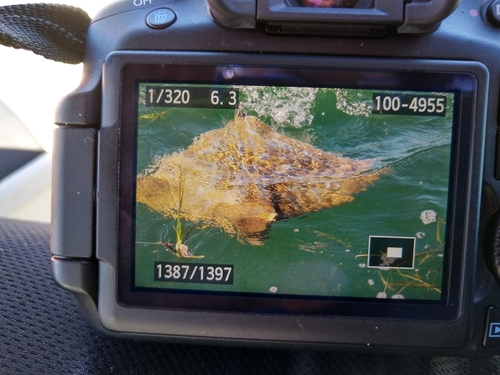

In [7]:
img_root = "imagenet-a/"

imagenet_a = S3ImageFolder(img_root)

print(len(imagenet_a))
print(imagenet_a[0])
imagenet_a[0][0]

In [8]:
# subset of 200 classes from 1000 of ImageNet 1K

import torchvision.transforms as trn

thousand_k_to_200 = {0: -1, 1: -1, 2: -1, 3: -1, 4: -1, 5: -1, 6: 0, 7: -1, 8: -1, 9: -1, 10: -1, 11: 1, 12: -1, 13: 2,
                     14: -1, 15: 3, 16: -1, 17: 4, 18: -1, 19: -1, 20: -1, 21: -1, 22: 5, 23: 6, 24: -1, 25: -1, 26: -1,
                     27: 7, 28: -1, 29: -1, 30: 8, 31: -1, 32: -1, 33: -1, 34: -1, 35: -1, 36: -1, 37: 9, 38: -1,
                     39: 10, 40: -1, 41: -1, 42: 11, 43: -1, 44: -1, 45: -1, 46: -1, 47: 12, 48: -1, 49: -1, 50: 13,
                     51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: 14, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1,
                     63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: 15, 71: 16, 72: -1, 73: -1, 74: -1,
                     75: -1, 76: 17, 77: -1, 78: -1, 79: 18, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1,
                     87: -1, 88: -1, 89: 19, 90: 20, 91: -1, 92: -1, 93: -1, 94: 21, 95: -1, 96: 22, 97: 23, 98: -1,
                     99: 24, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: 25, 106: -1, 107: 26, 108: 27, 109: -1,
                     110: 28, 111: -1, 112: -1, 113: 29, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1,
                     121: -1, 122: -1, 123: -1, 124: 30, 125: 31, 126: -1, 127: -1, 128: -1, 129: -1, 130: 32, 131: -1,
                     132: 33, 133: -1, 134: -1, 135: -1, 136: -1, 137: -1, 138: -1, 139: -1, 140: -1, 141: -1, 142: -1,
                     143: 34, 144: 35, 145: -1, 146: -1, 147: -1, 148: -1, 149: -1, 150: 36, 151: 37, 152: -1, 153: -1,
                     154: -1, 155: -1, 156: -1, 157: -1, 158: -1, 159: -1, 160: -1, 161: -1, 162: -1, 163: -1, 164: -1,
                     165: -1, 166: -1, 167: -1, 168: -1, 169: -1, 170: -1, 171: -1, 172: -1, 173: -1, 174: -1, 175: -1,
                     176: -1, 177: -1, 178: -1, 179: -1, 180: -1, 181: -1, 182: -1, 183: -1, 184: -1, 185: -1, 186: -1,
                     187: -1, 188: -1, 189: -1, 190: -1, 191: -1, 192: -1, 193: -1, 194: -1, 195: -1, 196: -1, 197: -1,
                     198: -1, 199: -1, 200: -1, 201: -1, 202: -1, 203: -1, 204: -1, 205: -1, 206: -1, 207: 38, 208: -1,
                     209: -1, 210: -1, 211: -1, 212: -1, 213: -1, 214: -1, 215: -1, 216: -1, 217: -1, 218: -1, 219: -1,
                     220: -1, 221: -1, 222: -1, 223: -1, 224: -1, 225: -1, 226: -1, 227: -1, 228: -1, 229: -1, 230: -1,
                     231: -1, 232: -1, 233: -1, 234: 39, 235: 40, 236: -1, 237: -1, 238: -1, 239: -1, 240: -1, 241: -1,
                     242: -1, 243: -1, 244: -1, 245: -1, 246: -1, 247: -1, 248: -1, 249: -1, 250: -1, 251: -1, 252: -1,
                     253: -1, 254: 41, 255: -1, 256: -1, 257: -1, 258: -1, 259: -1, 260: -1, 261: -1, 262: -1, 263: -1,
                     264: -1, 265: -1, 266: -1, 267: -1, 268: -1, 269: -1, 270: -1, 271: -1, 272: -1, 273: -1, 274: -1,
                     275: -1, 276: -1, 277: 42, 278: -1, 279: -1, 280: -1, 281: -1, 282: -1, 283: 43, 284: -1, 285: -1,
                     286: -1, 287: 44, 288: -1, 289: -1, 290: -1, 291: 45, 292: -1, 293: -1, 294: -1, 295: 46, 296: -1,
                     297: -1, 298: 47, 299: -1, 300: -1, 301: 48, 302: -1, 303: -1, 304: -1, 305: -1, 306: 49, 307: 50,
                     308: 51, 309: 52, 310: 53, 311: 54, 312: -1, 313: 55, 314: 56, 315: 57, 316: -1, 317: 58, 318: -1,
                     319: 59, 320: -1, 321: -1, 322: -1, 323: 60, 324: 61, 325: -1, 326: 62, 327: 63, 328: -1, 329: -1,
                     330: 64, 331: -1, 332: -1, 333: -1, 334: 65, 335: 66, 336: 67, 337: -1, 338: -1, 339: -1, 340: -1,
                     341: -1, 342: -1, 343: -1, 344: -1, 345: -1, 346: -1, 347: 68, 348: -1, 349: -1, 350: -1, 351: -1,
                     352: -1, 353: -1, 354: -1, 355: -1, 356: -1, 357: -1, 358: -1, 359: -1, 360: -1, 361: 69, 362: -1,
                     363: 70, 364: -1, 365: -1, 366: -1, 367: -1, 368: -1, 369: -1, 370: -1, 371: -1, 372: 71, 373: -1,
                     374: -1, 375: -1, 376: -1, 377: -1, 378: 72, 379: -1, 380: -1, 381: -1, 382: -1, 383: -1, 384: -1,
                     385: -1, 386: 73, 387: -1, 388: -1, 389: -1, 390: -1, 391: -1, 392: -1, 393: -1, 394: -1, 395: -1,
                     396: -1, 397: 74, 398: -1, 399: -1, 400: 75, 401: 76, 402: 77, 403: -1, 404: 78, 405: -1, 406: -1,
                     407: 79, 408: -1, 409: -1, 410: -1, 411: 80, 412: -1, 413: -1, 414: -1, 415: -1, 416: 81, 417: 82,
                     418: -1, 419: -1, 420: 83, 421: -1, 422: -1, 423: -1, 424: -1, 425: 84, 426: -1, 427: -1, 428: 85,
                     429: -1, 430: 86, 431: -1, 432: -1, 433: -1, 434: -1, 435: -1, 436: -1, 437: 87, 438: 88, 439: -1,
                     440: -1, 441: -1, 442: -1, 443: -1, 444: -1, 445: 89, 446: -1, 447: -1, 448: -1, 449: -1, 450: -1,
                     451: -1, 452: -1, 453: -1, 454: -1, 455: -1, 456: 90, 457: 91, 458: -1, 459: -1, 460: -1, 461: 92,
                     462: 93, 463: -1, 464: -1, 465: -1, 466: -1, 467: -1, 468: -1, 469: -1, 470: 94, 471: -1, 472: 95,
                     473: -1, 474: -1, 475: -1, 476: -1, 477: -1, 478: -1, 479: -1, 480: -1, 481: -1, 482: -1, 483: 96,
                     484: -1, 485: -1, 486: 97, 487: -1, 488: 98, 489: -1, 490: -1, 491: -1, 492: 99, 493: -1, 494: -1,
                     495: -1, 496: 100, 497: -1, 498: -1, 499: -1, 500: -1, 501: -1, 502: -1, 503: -1, 504: -1, 505: -1,
                     506: -1, 507: -1, 508: -1, 509: -1, 510: -1, 511: -1, 512: -1, 513: -1, 514: 101, 515: -1,
                     516: 102, 517: -1, 518: -1, 519: -1, 520: -1, 521: -1, 522: -1, 523: -1, 524: -1, 525: -1, 526: -1,
                     527: -1, 528: 103, 529: -1, 530: 104, 531: -1, 532: -1, 533: -1, 534: -1, 535: -1, 536: -1,
                     537: -1, 538: -1, 539: 105, 540: -1, 541: -1, 542: 106, 543: 107, 544: -1, 545: -1, 546: -1,
                     547: -1, 548: -1, 549: 108, 550: -1, 551: -1, 552: 109, 553: -1, 554: -1, 555: -1, 556: -1,
                     557: 110, 558: -1, 559: -1, 560: -1, 561: 111, 562: 112, 563: -1, 564: -1, 565: -1, 566: -1,
                     567: -1, 568: -1, 569: 113, 570: -1, 571: -1, 572: 114, 573: 115, 574: -1, 575: 116, 576: -1,
                     577: -1, 578: -1, 579: 117, 580: -1, 581: -1, 582: -1, 583: -1, 584: -1, 585: -1, 586: -1, 587: -1,
                     588: -1, 589: 118, 590: -1, 591: -1, 592: -1, 593: -1, 594: -1, 595: -1, 596: -1, 597: -1, 598: -1,
                     599: -1, 600: -1, 601: -1, 602: -1, 603: -1, 604: -1, 605: -1, 606: 119, 607: 120, 608: -1,
                     609: 121, 610: -1, 611: -1, 612: -1, 613: -1, 614: 122, 615: -1, 616: -1, 617: -1, 618: -1,
                     619: -1, 620: -1, 621: -1, 622: -1, 623: -1, 624: -1, 625: -1, 626: 123, 627: 124, 628: -1,
                     629: -1, 630: -1, 631: -1, 632: -1, 633: -1, 634: -1, 635: -1, 636: -1, 637: -1, 638: -1, 639: -1,
                     640: 125, 641: 126, 642: 127, 643: 128, 644: -1, 645: -1, 646: -1, 647: -1, 648: -1, 649: -1,
                     650: -1, 651: -1, 652: -1, 653: -1, 654: -1, 655: -1, 656: -1, 657: -1, 658: 129, 659: -1, 660: -1,
                     661: -1, 662: -1, 663: -1, 664: -1, 665: -1, 666: -1, 667: -1, 668: 130, 669: -1, 670: -1, 671: -1,
                     672: -1, 673: -1, 674: -1, 675: -1, 676: -1, 677: 131, 678: -1, 679: -1, 680: -1, 681: -1,
                     682: 132, 683: -1, 684: 133, 685: -1, 686: -1, 687: 134, 688: -1, 689: -1, 690: -1, 691: -1,
                     692: -1, 693: -1, 694: -1, 695: -1, 696: -1, 697: -1, 698: -1, 699: -1, 700: -1, 701: 135, 702: -1,
                     703: -1, 704: 136, 705: -1, 706: -1, 707: -1, 708: -1, 709: -1, 710: -1, 711: -1, 712: -1, 713: -1,
                     714: -1, 715: -1, 716: -1, 717: -1, 718: -1, 719: 137, 720: -1, 721: -1, 722: -1, 723: -1, 724: -1,
                     725: -1, 726: -1, 727: -1, 728: -1, 729: -1, 730: -1, 731: -1, 732: -1, 733: -1, 734: -1, 735: -1,
                     736: 138, 737: -1, 738: -1, 739: -1, 740: -1, 741: -1, 742: -1, 743: -1, 744: -1, 745: -1,
                     746: 139, 747: -1, 748: -1, 749: 140, 750: -1, 751: -1, 752: 141, 753: -1, 754: -1, 755: -1,
                     756: -1, 757: -1, 758: 142, 759: -1, 760: -1, 761: -1, 762: -1, 763: 143, 764: -1, 765: 144,
                     766: -1, 767: -1, 768: 145, 769: -1, 770: -1, 771: -1, 772: -1, 773: 146, 774: 147, 775: -1,
                     776: 148, 777: -1, 778: -1, 779: 149, 780: 150, 781: -1, 782: -1, 783: -1, 784: -1, 785: -1,
                     786: 151, 787: -1, 788: -1, 789: -1, 790: -1, 791: -1, 792: 152, 793: -1, 794: -1, 795: -1,
                     796: -1, 797: 153, 798: -1, 799: -1, 800: -1, 801: -1, 802: 154, 803: 155, 804: 156, 805: -1,
                     806: -1, 807: -1, 808: -1, 809: -1, 810: -1, 811: -1, 812: -1, 813: 157, 814: -1, 815: 158,
                     816: -1, 817: -1, 818: -1, 819: -1, 820: 159, 821: -1, 822: -1, 823: 160, 824: -1, 825: -1,
                     826: -1, 827: -1, 828: -1, 829: -1, 830: -1, 831: 161, 832: -1, 833: 162, 834: -1, 835: 163,
                     836: -1, 837: -1, 838: -1, 839: 164, 840: -1, 841: -1, 842: -1, 843: -1, 844: -1, 845: 165,
                     846: -1, 847: 166, 848: -1, 849: -1, 850: 167, 851: -1, 852: -1, 853: -1, 854: -1, 855: -1,
                     856: -1, 857: -1, 858: -1, 859: 168, 860: -1, 861: -1, 862: 169, 863: -1, 864: -1, 865: -1,
                     866: -1, 867: -1, 868: -1, 869: -1, 870: 170, 871: -1, 872: -1, 873: -1, 874: -1, 875: -1, 876: -1,
                     877: -1, 878: -1, 879: 171, 880: 172, 881: -1, 882: -1, 883: -1, 884: -1, 885: -1, 886: -1,
                     887: -1, 888: 173, 889: -1, 890: 174, 891: -1, 892: -1, 893: -1, 894: -1, 895: -1, 896: -1,
                     897: 175, 898: -1, 899: -1, 900: 176, 901: -1, 902: -1, 903: -1, 904: -1, 905: -1, 906: -1,
                     907: 177, 908: -1, 909: -1, 910: -1, 911: -1, 912: -1, 913: 178, 914: -1, 915: -1, 916: -1,
                     917: -1, 918: -1, 919: -1, 920: -1, 921: -1, 922: -1, 923: -1, 924: 179, 925: -1, 926: -1, 927: -1,
                     928: -1, 929: -1, 930: -1, 931: -1, 932: 180, 933: 181, 934: 182, 935: -1, 936: -1, 937: 183,
                     938: -1, 939: -1, 940: -1, 941: -1, 942: -1, 943: 184, 944: -1, 945: 185, 946: -1, 947: 186,
                     948: -1, 949: -1, 950: -1, 951: 187, 952: -1, 953: -1, 954: 188, 955: -1, 956: 189, 957: 190,
                     958: -1, 959: 191, 960: -1, 961: -1, 962: -1, 963: -1, 964: -1, 965: -1, 966: -1, 967: -1, 968: -1,
                     969: -1, 970: -1, 971: 192, 972: 193, 973: -1, 974: -1, 975: -1, 976: -1, 977: -1, 978: -1,
                     979: -1, 980: 194, 981: 195, 982: -1, 983: -1, 984: 196, 985: -1, 986: 197, 987: 198, 988: 199,
                     989: -1, 990: -1, 991: -1, 992: -1, 993: -1, 994: -1, 995: -1, 996: -1, 997: -1, 998: -1, 999: -1}

indices_in_1k = [k for k in thousand_k_to_200 if thousand_k_to_200[k] != -1]

# TODO to complete

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

test_transform = trn.Compose(
    [trn.Resize(256), trn.CenterCrop(224), trn.ToTensor(), trn.Normalize(mean, std)])

In [14]:
## from https://github.com/hendrycks/natural-adv-examples/blob/master/eval.py

import torchvision.models as models

img_root = "imagenet-a/"
BATCH_SIZE = 128

dataset = S3ImageFolder(img_root, transform=test_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model = models.resnet50(pretrained=True)

num_inftr = model.fc.in_features
model.fc = nn.Linear(num_inftr, 200)

model.cuda()
model.eval()

def get_net_results():
    confidence = []
    correct = []

    num_correct = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(nae_loader):
            data, target = data.cuda(), target.cuda()

            output = net(data)[:,indices_in_1k]

            # accuracy
            pred = output.data.max(1)[1]
            num_correct += pred.eq(target.data).sum().item()

            confidence.extend(to_np(F.softmax(output, dim=1).max(1)[0]).squeeze().tolist())
            pred = output.data.max(1)[1]
            correct.extend(pred.eq(target).to('cpu').numpy().squeeze().tolist())

    return num_correct / len(nae_loader.dataset), confidence.copy(), correct.copy()


acc, test_confidence, test_correct = get_net_results()

print('ImageNet-A Accuracy (%):', round(100*acc, 4))

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can als

AssertionError: Torch not compiled with CUDA enabled

In [4]:
imagenet_a.class_to_idx

{'n01498041': 0,
 'n01531178': 1,
 'n01534433': 2,
 'n01558993': 3,
 'n01580077': 4,
 'n01614925': 5,
 'n01616318': 6,
 'n01631663': 7,
 'n01641577': 8,
 'n01669191': 9,
 'n01677366': 10,
 'n01687978': 11,
 'n01694178': 12,
 'n01698640': 13,
 'n01735189': 14,
 'n01770081': 15,
 'n01770393': 16,
 'n01774750': 17,
 'n01784675': 18,
 'n01819313': 19,
 'n01820546': 20,
 'n01833805': 21,
 'n01843383': 22,
 'n01847000': 23,
 'n01855672': 24,
 'n01882714': 25,
 'n01910747': 26,
 'n01914609': 27,
 'n01924916': 28,
 'n01944390': 29,
 'n01985128': 30,
 'n01986214': 31,
 'n02007558': 32,
 'n02009912': 33,
 'n02037110': 34,
 'n02051845': 35,
 'n02077923': 36,
 'n02085620': 37,
 'n02099601': 38,
 'n02106550': 39,
 'n02106662': 40,
 'n02110958': 41,
 'n02119022': 42,
 'n02123394': 43,
 'n02127052': 44,
 'n02129165': 45,
 'n02133161': 46,
 'n02137549': 47,
 'n02165456': 48,
 'n02174001': 49,
 'n02177972': 50,
 'n02190166': 51,
 'n02206856': 52,
 'n02219486': 53,
 'n02226429': 54,
 'n02231487': 55,
 '

In [10]:
## from https://github.com/facebookresearch/SWAG/blob/main/inference_tutorial.ipynb

!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json -O in_cls_idx.json --no-check-certificate

import json

with open("in_cls_idx.json", "r") as f:
    imagenet_id_to_name = {int(cls_id): name for cls_id, (label, name) in json.load(f).items()}

# let's preview the first few class names 
dict(sorted(imagenet_id_to_name.items())[: 200])

--2024-07-16 15:00:09--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.56.128, 52.216.218.176, 52.217.201.48, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.56.128|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/octet-stream]
Saving to: ‘in_cls_idx.json’

in_cls_idx.json     100%[===================>]  34.53K  --.-KB/s    in 0.07s   

2024-07-16 15:00:09 (507 KB/s) - ‘in_cls_idx.json’ saved [35363/35363]



{0: 'tench',
 1: 'goldfish',
 2: 'great_white_shark',
 3: 'tiger_shark',
 4: 'hammerhead',
 5: 'electric_ray',
 6: 'stingray',
 7: 'cock',
 8: 'hen',
 9: 'ostrich',
 10: 'brambling',
 11: 'goldfinch',
 12: 'house_finch',
 13: 'junco',
 14: 'indigo_bunting',
 15: 'robin',
 16: 'bulbul',
 17: 'jay',
 18: 'magpie',
 19: 'chickadee',
 20: 'water_ouzel',
 21: 'kite',
 22: 'bald_eagle',
 23: 'vulture',
 24: 'great_grey_owl',
 25: 'European_fire_salamander',
 26: 'common_newt',
 27: 'eft',
 28: 'spotted_salamander',
 29: 'axolotl',
 30: 'bullfrog',
 31: 'tree_frog',
 32: 'tailed_frog',
 33: 'loggerhead',
 34: 'leatherback_turtle',
 35: 'mud_turtle',
 36: 'terrapin',
 37: 'box_turtle',
 38: 'banded_gecko',
 39: 'common_iguana',
 40: 'American_chameleon',
 41: 'whiptail',
 42: 'agama',
 43: 'frilled_lizard',
 44: 'alligator_lizard',
 45: 'Gila_monster',
 46: 'green_lizard',
 47: 'African_chameleon',
 48: 'Komodo_dragon',
 49: 'African_crocodile',
 50: 'American_alligator',
 51: 'triceratops',
 

2


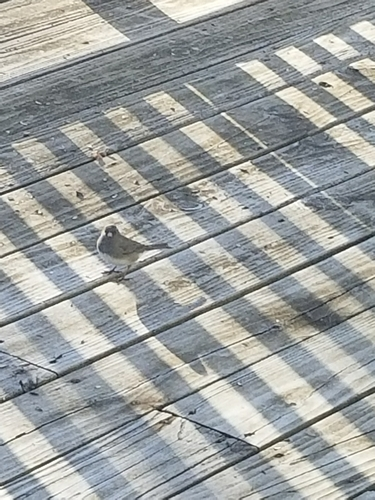

In [15]:
id = 200

print(imagenet_a[id][1])
imagenet_a[id][0]

In [6]:
len(imagenet_a.classes)

200

In [9]:
imagenet_id_to_name[imagenet_a.classes[0]]

KeyError: 'n01498041'

In [38]:
def get_data(batch_size, img_root):
    # Prepare data transformations for the train loader
    transform = T.Compose([
        T.Resize((256, 256)),                                                   # Resize each PIL image to 256 x 256
        T.RandomCrop((224, 224)),                                               # Randomly crop a 224 x 224 patch
        T.ToTensor(),                                                           # Convert Numpy to Pytorch Tensor
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),     # Normalize with ImageNet mean

        # ViT_B_16_Weights.DEFAULT.transforms()        # TODO: is this correct here?
    ])

    # Load data
    dataset = S3ImageFolder(root=img_root, transform=transform)

    # Create train and test splits (80/20)
    num_samples = len(dataset)
    training_samples = int(num_samples * 0.8 + 1)
    test_samples = num_samples - training_samples

    training_data, test_data = torch.utils.data.random_split(dataset, [training_samples, test_samples])

    # Initialize dataloaders
    train_loader = torch.utils.data.DataLoader(training_data, batch_size, shuffle=True, num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False, num_workers=4)

    return train_loader, test_loader

In [40]:
transform = T.Compose([
    T.Resize((256, 256)),                                                   # Resize each PIL image to 256 x 256
    T.RandomCrop((224, 224)),                                               # Randomly crop a 224 x 224 patch
    T.ToTensor(),                                                           # Convert Numpy to Pytorch Tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),     # Normalize with ImageNet mean

    # ViT_B_16_Weights.DEFAULT.transforms()        # TODO: is this correct here?
])

# Load data
dataset = S3ImageFolder(root=img_root, transform=transform)

# Create train and test splits (80/20)
num_samples = len(dataset)
training_samples = int(num_samples * 0.8 + 1)
test_samples = num_samples - training_samples

training_data, test_data = torch.utils.data.random_split(dataset, [training_samples, test_samples])

torch.Size([3, 224, 224])


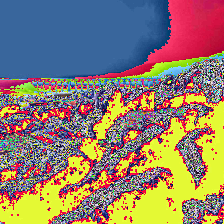

In [55]:
img = training_data[0][0]
label = training_data[0][1]

print(img.shape)

transform = T.ToPILImage()
img_orig = transform(img)
img_orig.show()


## Model
ViT-b/16

In [5]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

# TODO: add ResNet
# TODO: add nn.DataParallel(model)

def build_model():
    return vit_b_16(pretrained=True)

## Cost function

In [14]:
# TODO make as function

class MarginalEntropy(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs):
        # compute mean entropy
        logits = outputs - outputs.logsumexp(dim=-1, keepdim=True)
        avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0])
        min_real = torch.finfo(avg_logits.dtype).min
        avg_logits = torch.clamp(avg_logits, min=min_real)
        mean_entropy = -(avg_logits * torch.exp(avg_logits)).sum(dim=-1), avg_logits
        return mean_entropy

loss_fn = MarginalEntropy()

## Augmentations for MEMO

### Augmix

In [ ]:
## https://github.com/google-research/augmix

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
preaugment = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
])
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

def _augmix_aug(x_orig):
    x_orig = preaugment(x_orig)
    x_processed = preprocess(x_orig)
    w = np.float32(np.random.dirichlet([1.0, 1.0, 1.0]))
    m = np.float32(np.random.beta(1.0, 1.0))

    mix = torch.zeros_like(x_processed)
    for i in range(3):                                      # repeat process
        x_aug = x_orig.copy()
        for _ in range(np.random.randint(1, 4)):            # how many filter apply
            x_aug = np.random.choice(augmentations)(x_aug)  # pick randomly
        mix += w[i] * preprocess(x_aug)                     # multiply by a magnitude ??
    mix = m * x_processed + (1 - m) * mix
    return mix

# -------------------------------------------------------------------------

def autocontrast(pil_img, level=None):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, level=None):
    return ImageOps.equalize(pil_img)


def rotate(pil_img, level):
    degrees = int_parameter(rand_lvl(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR, fillcolor=128)


def solarize(pil_img, level):
    level = int_parameter(rand_lvl(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(rand_lvl(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((224, 224), Image.AFFINE, (1, level, 0, 0, 1, 0), resample=Image.BILINEAR, fillcolor=128)


def shear_y(pil_img, level):
    level = float_parameter(rand_lvl(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((224, 224), Image.AFFINE, (1, 0, 0, level, 1, 0), resample=Image.BILINEAR, fillcolor=128)


def translate_x(pil_img, level):
    level = int_parameter(rand_lvl(level), 224 / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((224, 224), Image.AFFINE, (1, 0, level, 0, 1, 0), resample=Image.BILINEAR, fillcolor=128)


def translate_y(pil_img, level):
    level = int_parameter(rand_lvl(level), 224 / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((224, 224), Image.AFFINE, (1, 0, 0, 0, 1, level), resample=Image.BILINEAR, fillcolor=128)


def posterize(pil_img, level):
    level = int_parameter(rand_lvl(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
    Returns:
    An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.
    Returns:
    A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def rand_lvl(n):
    return np.random.uniform(low=0.1, high=n)

In [ ]:
augmentations = [
    autocontrast,
    equalize,
    lambda x: rotate(x, 1),
    lambda x: solarize(x, 1),
    lambda x: shear_x(x, 1),
    lambda x: shear_y(x, 1),
    lambda x: translate_x(x, 1),
    lambda x: translate_y(x, 1),
    lambda x: posterize(x, 1),
]

### Idea: Random Patch Hiding

In [ ]:
def random_hide_patch(img):
    # get width and height of the image
    _, H, W = img.shape

    patch_size = int(min(H, W) * 0.1)  # Example: 10% of the shorter side of the image

    # Create a copy of the image to avoid modifying the original image
    masked_img = img.clone()

    hide_prob = 0.3

    for x in range(0, W, patch_size):
        for y in range(0, H, patch_size):
            x_end = min(W, x + patch_size)
            y_end = min(H, y + patch_size)
            choose_to_hide = random.uniform(0, 1)
            if choose_to_hide <= hide_prob:
                masked_img[:, y:y_end, x:x_end] = 0

    return masked_img

## Training and Test steps

In [4]:
def test(model, data_loader, cost_function, device="cuda"):
    model.eval()

    samples = 0.0
    cumulative_loss = 0.0
    cumulative_accuracy = 0.0

    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = cost_function(outputs, targets)

            samples += inputs.shape[0]
            cumulative_loss += loss.item()
            _, predicted = outputs.max(1)

            cumulative_accuracy += predicted.eq(targets).sum().item()

    return cumulative_loss / samples, cumulative_accuracy / samples * 100


def test_single(adapted_model, sample, BN_prior_strength=None):
    adapted_model.eval()

    # if BN_prior_strength is not None:
    #     nn.BatchNorm2d.prior = float(BN_prior_strength) / float(BN_prior_strength + 1)

    sample = sample.unsqueeze(0)  # create a mini-batch as expected by the resnet model

    with torch.no_grad():
        outputs = adapted_model(sample.cuda())
        outputs = outputs[:, indices_in_1k]
        _, predicted = outputs.max(1)
    prediction = predicted.item()

    # if BN_prior_strength is not None:
    #     nn.BatchNorm2d.prior = 1

    return prediction

### MEMO implementation

In [6]:
def memo_tta(pretrained_model, sample, epochs_for_adaptation, BN_prior_strenght=None, num_augmentations=16):
    optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=learning_rate)

    augmented_samples = []
    
    # TODO how to parallelize this
    for _ in range(num_augmentations):
        augmented_sample = augmix(sample)
        augmented_samples.append(augmented_sample)
    augmented_samples = torch.stack(augmented_samples)

    pretrained_model.eval()

    # TODO how to use BN?
    # if BN_prior_strength is not None:
    #     nn.BatchNorm2d.prior = float(BN_prior_strength) / float(BN_prior_strength + 1)

    for epoch in range(epochs_for_adaptation):
        output_distributions = pretrained_model(augmented_samples)
        output_distributions = output_distributions[:, indices_in_1k]       # take from adversarial examples
    
        loss, _ = loss_fn(output_distributions)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # TODO Adapting BN statistics, maybe in adapt_single()
    # if BN_prior_strength is not None:
    #     nn.BatchNorm2d.prior = 1
    
    return pretrained_model

---

## Experiments

In [8]:
IMG_ROOT = "imagenet-a/"
BATCH_SIZE = 32  # TODO: to change?

train_loader, test_loader = get_data(BATCH_SIZE, IMG_ROOT)

cost_function = torch.nn.CrossEntropyLoss()

model = build_model()

# model.cuda()
model.eval()

loss, accuracy = test(model, test_loader, cost_function, device="cpu")
print(loss, accuracy)


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can als

KeyboardInterrupt: 

In [ ]:
# implementation of: test time adaptation via MEMO

# "only one gradient step per test point" as per paper
epochs_for_adaptation = 1

correct_predictions = 0

for batch_idx, (inputs, targets) in enumerate(train_loader):

    pretrained_model = build_model()
    adapted_model = memo_tta(pretrained_model, input_image, epochs_for_adaptation)

    # inference phase
    # TODO change prior_strength
    prediction = test_single(adapted_model, input_image, -1)
    correctness = 1 if prediction == input_label else 0
    correct_predictions += correctness